## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
from altair import *
%matplotlib inline

In [2]:
from ipywidgets import interact, fixed
from IPython.display import display

## Exploratory Data Analysis

### Reading CSV Files

Now that I have removed and organized all the data, I now have a dataset that has everything that is useful for the data analysis. I will now import both datasets that are saved on the data folder so that I can use them for different forms of visualizations.

In [3]:
data = pd.read_csv('/data/glirios/Pokemon.csv', index_col=0)

In [4]:
data.head()

,pokemonId,latitude,longitude,appearedTimeOfDay,appearedDayOfWeek,appearedLocalTime,appearedHour,appearedDay,city,temperature,continent,population_density,class
0,16,20.525745,-97.460829,night,Monday,2016-09-08T03:57:45,5,8,Mexico_City,25.5,America,2431.2341,16
1,133,20.523695,-97.461167,night,Monday,2016-09-08T03:57:37,5,8,Mexico_City,25.5,America,2431.2341,133
2,16,38.903590,-77.199780,night,Monday,2016-09-08T03:57:25,5,8,New_York,24.2,America,761.8856,16
3,13,47.665903,-122.312561,night,Monday,2016-09-08T03:56:22,5,8,Los_Angeles,15.6,America,4842.1626,13
4,133,47.666454,-122.311628,night,Monday,2016-09-08T03:56:08,5,8,Los_Angeles,15.6,America,4842.1626,133


In [5]:
assert data.shape == (296021, 13)

In [6]:
locs = pd.read_csv('/data/glirios/poke_locs.csv', index_col = 0)

In [7]:
locs.head()

,city,latitude,longitude,appearedLocalTime
0,Mexico_City,20.525745,-97.460829,2016-09-08T03:57:45
1,Mexico_City,20.523695,-97.461167,2016-09-08T03:57:37
2,New_York,38.903590,-77.199780,2016-09-08T03:57:25
3,Los_Angeles,47.665903,-122.312561,2016-09-08T03:56:22
4,Los_Angeles,47.666454,-122.311628,2016-09-08T03:56:08


In [8]:
assert locs.shape == (296021, 4)

### Data Analysis Work

Now that the csv files have been added and checked for accurate information, we can now use the datasets to show visualizaitons on questions about the work. 

### Question 1
1: Where is all this inforamtion located? Since this information is gathered globally, we must know where exactly all this information is being received from. 

/opt/conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: The hold function was deprecated in version 2.0.
  ax.hold(b)


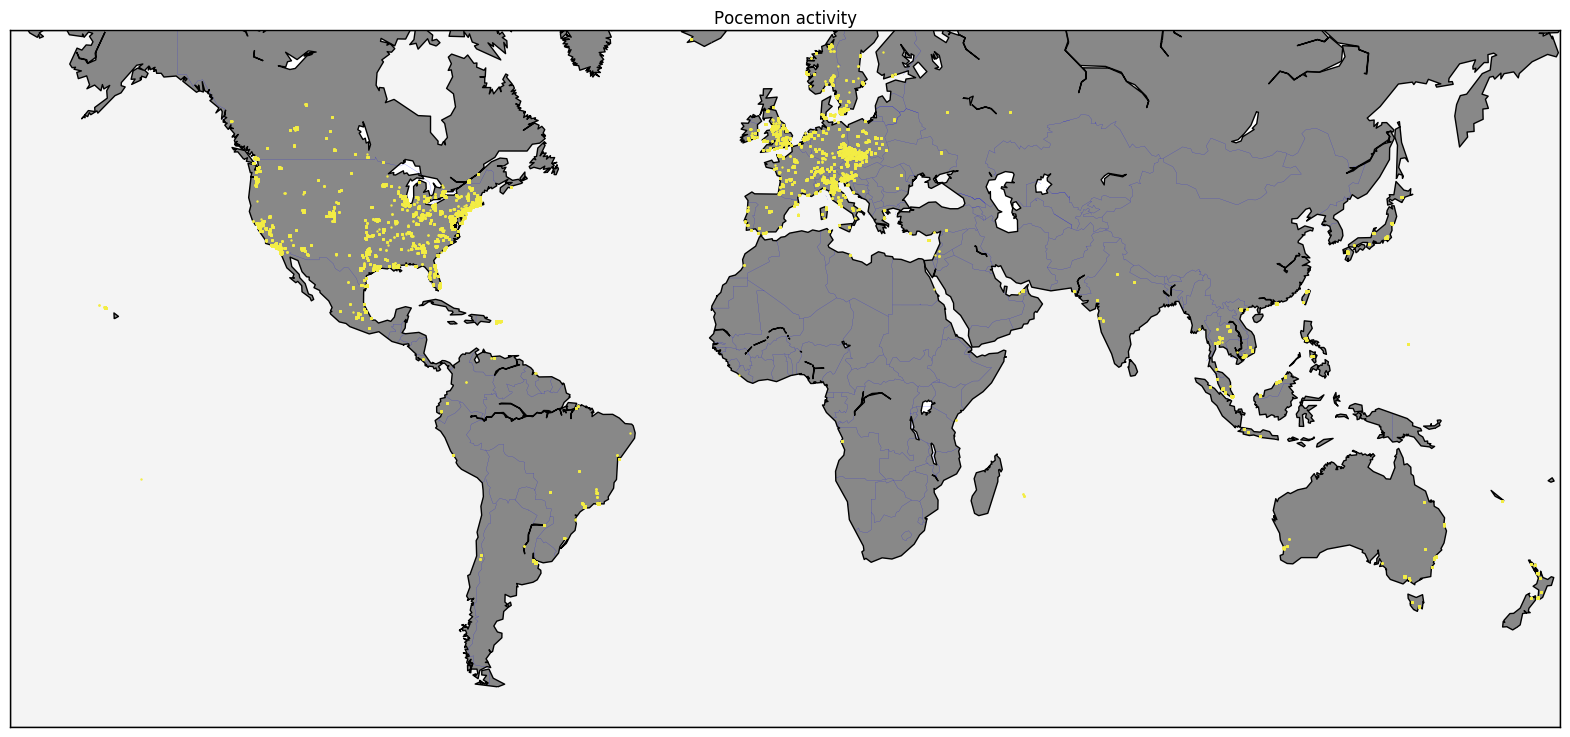

In [9]:
plt.figure(1, figsize=(20,10))
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#888888',lake_color='#FFFFFF') # light grey land, white lakes
m1.drawmapboundary(fill_color='#f4f4f4')                # dark outlines
m1.drawcountries(linewidth=0.1, color="b")              # thin black line for country borders
m1.drawcoastlines()

# Plot the data
x, y = m1(locs.longitude.tolist(),locs.latitude.tolist())
m1.scatter(x,y, s=3, c="#F3ED44", lw=0, alpha=1, zorder=5)
plt.title("Pocemon activity")
plt.show()

Since the dataset already provides longitutde and latitude coordinates, I was able to use the Basemap function provided by mpl_toolkits to display a map of the world. That and with the scatter function embedded into the Basemap, I was able to place yellow dots to signify where the information was located in terms of where on the world. This information is helpful to know where the majority of the information is based and where the outliers on the information may be. 

### Question 2

2: Where is all this data being collected?

In [ ]:
Chart(data).mark_bar().encode(
    X('appearedTimeOfDay'),
    Y('count(*)')
)

As all the visualizaiton shows, all the data that was collected by the organization seems to be during the night. This does make sense based on the poeple that play the game. This game was tailored towards students in college and high school. During the school year, more sutdents seem to have less time to play the game. It make sense that there is a lack of activity during day and morning. As students and other people finish their daily acitivities, they will be able to play more PokemonGo. It seems that the most time players were available was during the high and that would explain for the high volume of activity.

### Question 3

3: How many cities have Pokemon appearances that are over 5000?

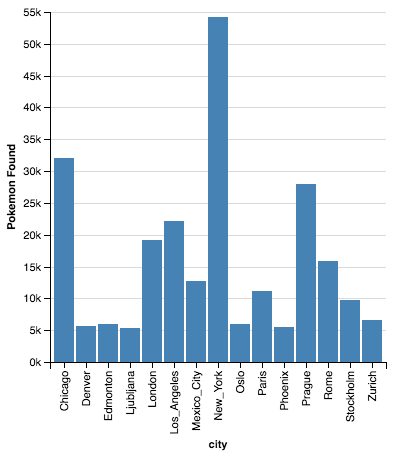

In [10]:
cnt = pd.DataFrame(data.groupby('city')['city'].size(), columns=['Pokemon Found'])
cnt = cnt[cnt['Pokemon Found'] > 5000]
Chart(cnt.reset_index()).mark_bar().encode(
    X('city'),
    Y('Pokemon Found')
)

The visualization shows that there 15 cities that have collected data on Pokemon appearances that exceeds over 5000. The two continents that seem to have the most data collected seem to be American and Europe. 

### Question 4

4: How time period is the best time to go search for pokemon based on the data provided?

In [11]:
poke_time = pd.DataFrame(data.groupby(['city', 'appearedTimeOfDay'])['city', 'appearedTimeOfDay'].size(), columns=['Pokemon Found'])

In [12]:
poke_time = poke_time[poke_time['Pokemon Found'] > 5000]

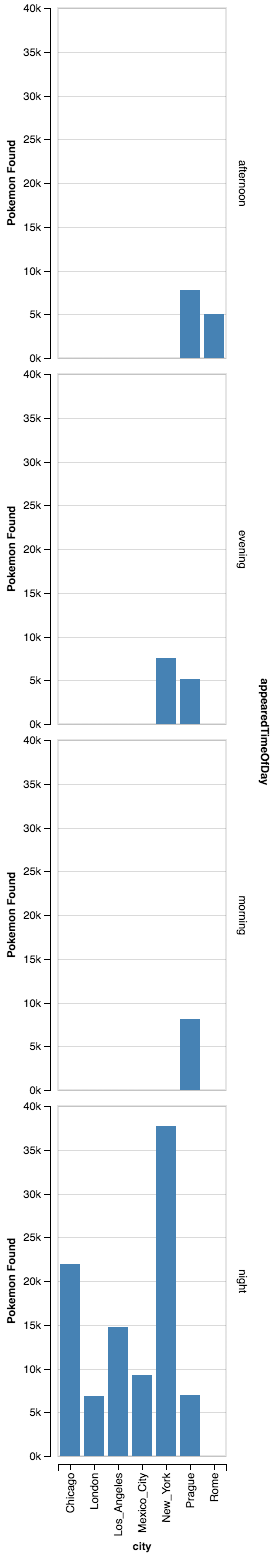

In [13]:
Chart(poke_time.reset_index()).mark_bar().encode(
    X('city'),
    Y('Pokemon Found'),
    Row('appearedTimeOfDay')
)

It seems that the best time to search for pokemon in a lot of cities is at night. 

### Question 5

5: How does the number of Pokemon appearances over 5000 change throughout each hour of the day?

In order to solve this question, I thought the best way to show the results would be through an interact button that would allow the user to change the hour of the day with a simple slider.

In [ ]:
def pokemon_hour(hour):
    # extract feature local time
    data['LocalTime'] = data.appearedLocalTime.apply(lambda x: x.split("T")[1])

    # grouping data by time (hour)
    loc_time = data.groupby(['city', data.LocalTime.map(lambda x: int(x.split(":")[0]))]).size()
    loc_time = loc_time.unstack()
    loc_time = loc_time.fillna(0)

    # plot grouping data
    f, axes = plt.subplots(1, 1, figsize=(25, 10))
    sns.barplot(x=loc_time.index, y=loc_time[hour], ax=axes)
    axes.set(ylabel="Count", title="Pokemon in City activity at %2d:00 Local time" %(hour))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

In [ ]:
interact(pokemon_hour, hour=(0,23,1))

The interact slider bar allows the user to move the cursor back and forth to any specific hour of the day. Since there are over 100,000 different data entries, the elapse time for the diagram to change is quick long. 